In [1]:
import pandas as pd
from prophet import Prophet
from prophet.plot import add_changepoints_to_plot
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics
from fbprophet.plot import plot_cross_validation_metric
from sklearn.metrics import r2_score

In [2]:
def read_data(f, cols, sep='[;,|_]', engine='python'):
    df = pd.read_csv(f, sep=sep, engine=engine, header=None)
    df.columns=cols
    return df

In [3]:
df = read_data('/Users/meghagodwal/Desktop/project 2_DS/SN_m_tot_V2.0.csv', 
              ['Year','Month','Decimal_date','y','Daily_std','No_observation','Provisonal_indicator'])
df.head()

,Year,Month,Decimal_date,y,Daily_std,No_observation,Provisonal_indicator
0,1749,1,1749.042,96.7,-1.0,-1,1
1,1749,2,1749.123,104.3,-1.0,-1,1
2,1749,3,1749.204,116.7,-1.0,-1,1
3,1749,4,1749.288,92.8,-1.0,-1,1
4,1749,5,1749.371,141.7,-1.0,-1,1


### Prep and clean monthly dataset

In [4]:
def get_day(rec):
    import datetime
    year = 366 if rec[0] % 4 == 0 else 365
    d = int(((rec['Decimal_date'] - rec['Year']) * year) + 0.5)
    x = datetime.datetime(int(rec['Year']), 1, 1) + datetime.timedelta(d - 1)
    # return int(x.date().day)
    return "{0}-{1}-{2}".format(int(rec['Year']), int(rec['Month']), int(x.date().day))

In [5]:
df = df[df.columns[:4]]
df['date'] = df.apply(get_day, axis=1)
df['ds'] = df['date'].apply(pd.to_datetime)
df

,Year,Month,Decimal_date,y,date,ds
0,1749,1,1749.042,96.7,1749-1-15,1749-01-15
1,1749,2,1749.123,104.3,1749-2-14,1749-02-14
2,1749,3,1749.204,116.7,1749-3-15,1749-03-15
3,1749,4,1749.288,92.8,1749-4-15,1749-04-15
4,1749,5,1749.371,141.7,1749-5-15,1749-05-15
...,...,...,...,...,...,...
3261,2020,10,2020.791,14.4,2020-10-16,2020-10-16
3262,2020,11,2020.873,34.0,2020-11-15,2020-11-15
3263,2020,12,2020.958,21.8,2020-12-16,2020-12-16
3264,2021,1,2021.042,10.4,2021-1-15,2021-01-15


In [6]:
df1 = df.drop(columns=['Decimal_date', 'Year','Month','date'])
df1

,y,ds
0,96.7,1749-01-15
1,104.3,1749-02-14
2,116.7,1749-03-15
3,92.8,1749-04-15
4,141.7,1749-05-15
...,...,...
3261,14.4,2020-10-16
3262,34.0,2020-11-15
3263,21.8,2020-12-16
3264,10.4,2021-01-15


In [7]:
df_monthly_with_outlier = df1[(df1[['y']] != -1).all(axis=1)]
df_monthly_with_outlier

,y,ds
0,96.7,1749-01-15
1,104.3,1749-02-14
2,116.7,1749-03-15
3,92.8,1749-04-15
4,141.7,1749-05-15
...,...,...
3261,14.4,2020-10-16
3262,34.0,2020-11-15
3263,21.8,2020-12-16
3264,10.4,2021-01-15


### Fitting the model

In [8]:
model = Prophet()
model.fit(df_monthly_with_outlier)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [9]:
future_monthly_with_outlier = model.make_future_dataframe(periods=0, freq='m', include_history = True)
forecast_monthly_with_outlier = model.predict(future_monthly_with_outlier)
forecast_monthly_with_outlier[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
3261,2020-10-16,61.962740,-32.289438,143.897533
3262,2020-11-15,59.353512,-21.339589,141.002144
3263,2020-12-16,61.037866,-24.594967,139.692596
3264,2021-01-15,57.698982,-25.034529,146.632552
3265,2021-02-14,60.837870,-20.834133,147.285563


### Outlier detection and removal

In [10]:
def remove_outliers(forecast, df):
    # detect outliers
    forecast["outlier"] = 0
    forecast["y"] = df["y"].reset_index(drop = True)
    forecast.loc[(forecast['y'] > forecast['yhat_upper']+5), 'outlier'] = -1
    forecast.loc[(forecast['y'] < forecast['yhat_lower']-5), 'outlier'] = -1
    print("Outliers: ", len(forecast[forecast['outlier'] == -1]))
    print("Total: ", len(df))
    print("Remaining: ", (len(df)-len(forecast[forecast['outlier'] == -1])))
    
    # remove outliers
    forecast = forecast[forecast['outlier'] == 0].reset_index(drop = True)
    return forecast

In [11]:
df_monthly_without_outlier = remove_outliers(forecast_monthly_with_outlier, df_monthly_with_outlier)

Outliers:  418
Total:  3266
Remaining:  2848


### Refitting the data

In [13]:
model = Prophet()
model.fit(df_monthly_without_outlier)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [14]:
future_monthly_without_outlier = model.make_future_dataframe(periods=0, freq='m', include_history = True)
forecast_monthly_without_outlier = model.predict(future_monthly_without_outlier)
forecast_monthly_without_outlier[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
2843,2020-10-16,56.196481,-6.559648,120.466663
2844,2020-11-15,51.610708,-7.815125,113.265622
2845,2020-12-16,52.854709,-5.060919,113.163362
2846,2021-01-15,52.592976,-6.384030,115.899736
2847,2021-02-14,54.932202,-2.520690,124.000017


# Linear Model

In [16]:
m = Prophet(daily_seasonality = False, yearly_seasonality = False, weekly_seasonality = False,
            n_changepoints = 25,
            interval_width = 1.0,
            changepoint_range = 0.8,
            changepoint_prior_scale = 30.0,
            seasonality_prior_scale= 20.0 )

model = m.fit(df_monthly_without_outlier)

## 1 month forecast

In [17]:
future_1_month = model.make_future_dataframe(periods = 1, freq='m')
forecast_1_month = model.predict(future_1_month)
forecast_1_month.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,1749-01-15,105.360321,-28.141400,259.187468,105.360321,105.360321,0.0,0.0,0.0,0.0,0.0,0.0,105.360321
1,1749-02-14,104.808320,-37.997424,262.306374,104.808320,104.808320,0.0,0.0,0.0,0.0,0.0,0.0,104.808320
2,1749-03-15,104.274718,-50.003911,249.007180,104.274718,104.274718,0.0,0.0,0.0,0.0,0.0,0.0,104.274718
3,1749-04-15,103.704316,-56.639311,233.402516,103.704316,103.704316,0.0,0.0,0.0,0.0,0.0,0.0,103.704316
4,1749-05-15,103.152315,-27.023133,259.908000,103.152315,103.152315,0.0,0.0,0.0,0.0,0.0,0.0,103.152315


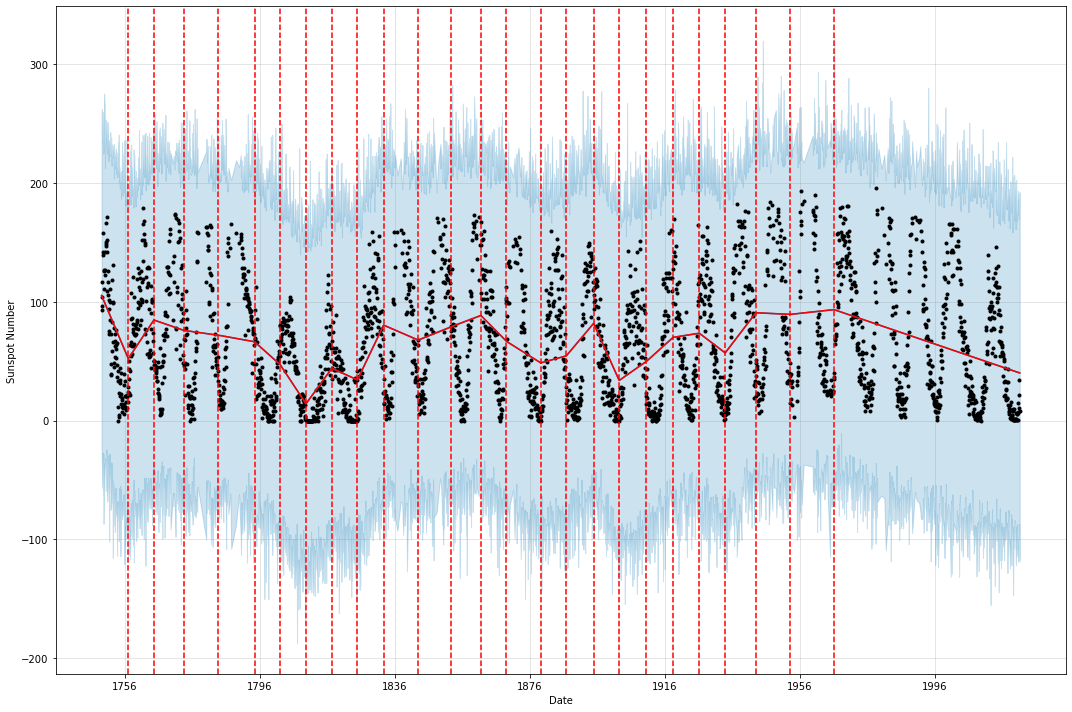

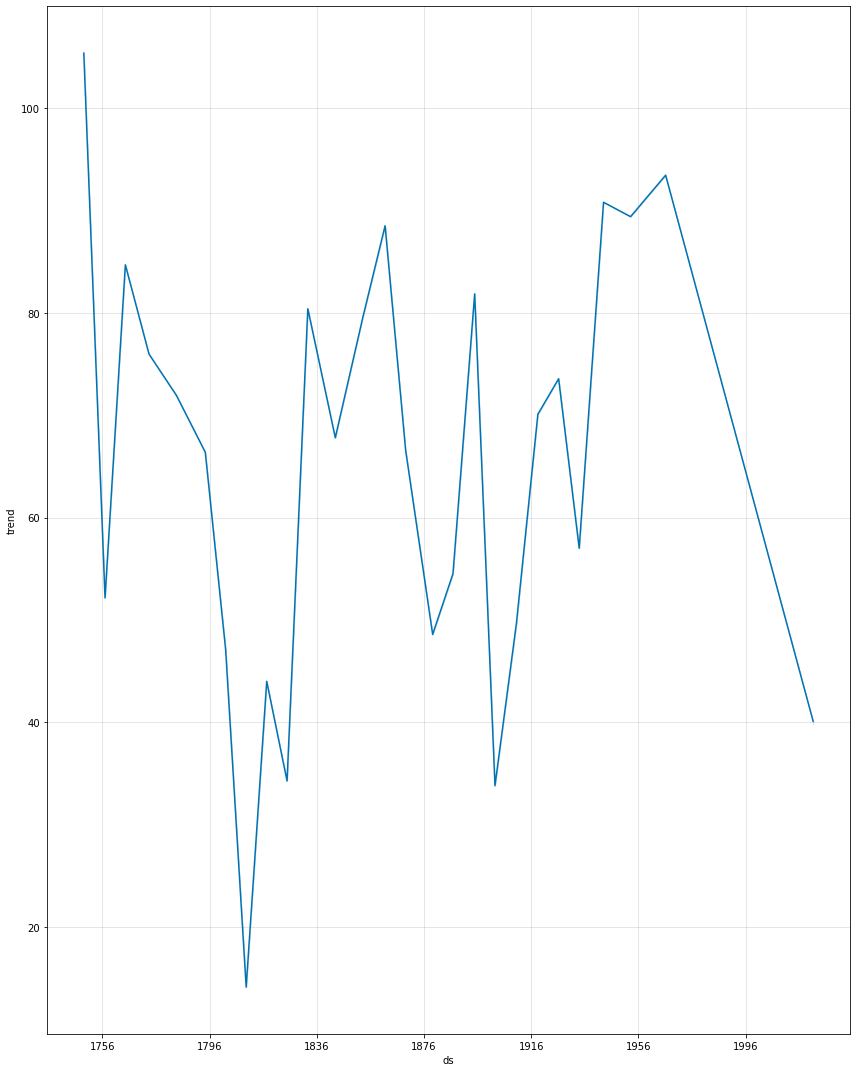

In [18]:
fig = model.plot(forecast_1_month, xlabel = "Date", ylabel = "Sunspot Number", figsize = (15,10))
a= add_changepoints_to_plot(fig.gca(),model,forecast_1_month)
fig1=model.plot_components(forecast_1_month, figsize=(12,15))

### Cross validation and Performance metrics

In [19]:
df_monthly_cv = cross_validation(model, initial='95000 days', period='30 days', horizon = '60 days', parallel = 'processes')

INFO:prophet:Making 144 forecasts with cutoffs between 2009-03-19 00:00:00 and 2020-12-16 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc771d830a0>


In [20]:
df_monthly_perf = performance_metrics(df_monthly_cv)
df_monthly_perf.head()

INFO:prophet:Skipping MAPE because y close to 0


,horizon,mse,rmse,mae,mdape,smape,coverage
0,7 days,507.650288,22.531096,18.708031,0.461195,0.467524,1.0
1,8 days,438.258109,20.934615,17.545207,0.410717,0.406846,1.0
2,9 days,592.832195,24.348146,21.677178,0.604769,0.510399,1.0
3,10 days,989.145996,31.450692,26.466420,0.657123,0.563262,1.0
4,11 days,1247.066812,35.313833,28.874848,0.655795,0.575640,1.0


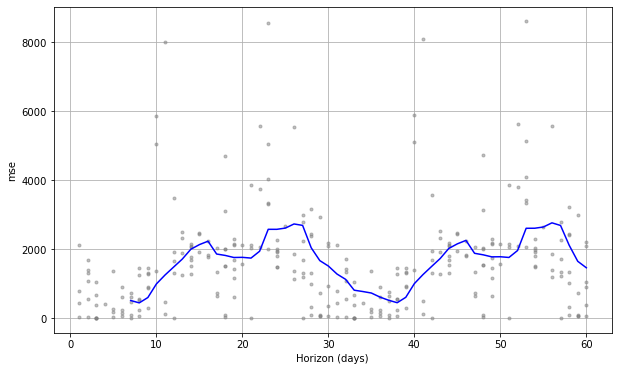

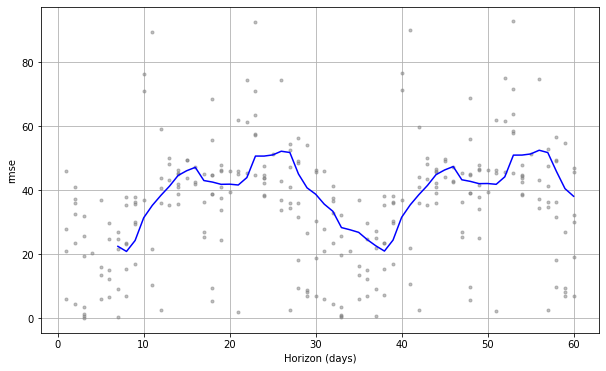

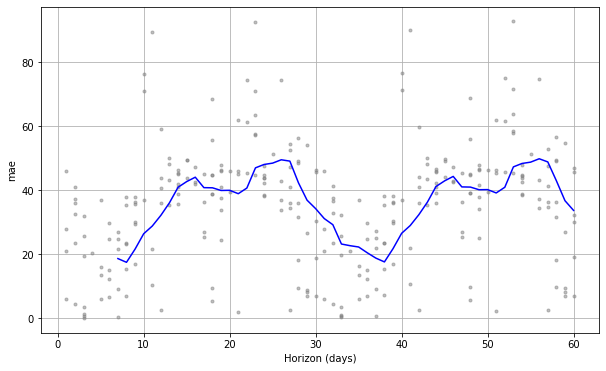

In [22]:
plt_mse = plot_cross_validation_metric(df_monthly_cv, metric='mse')

plt_rmse = plot_cross_validation_metric(df_monthly_cv, metric='rmse')

plt_mae = plot_cross_validation_metric(df_monthly_cv, metric='mae')

#plt_mape = plot_cross_validation_metric(df_monthly_cv, metric='mape')

In [24]:
r2_monthly= r2_score(df_monthly_cv['y'], df_monthly_cv['yhat'])
print('R2 Score :')
r2_monthly

R2 Score :


0.039657466606899616

## 6 month forecast

In [25]:
future_6_month = model.make_future_dataframe(periods = 6, freq='m')
forecast_6_month = model.predict(future_6_month)
forecast_6_month.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,1749-01-15,105.360321,-40.809064,247.594449,105.360321,105.360321,0.0,0.0,0.0,0.0,0.0,0.0,105.360321
1,1749-02-14,104.808320,-38.150014,241.847211,104.808320,104.808320,0.0,0.0,0.0,0.0,0.0,0.0,104.808320
2,1749-03-15,104.274718,-47.743248,282.738335,104.274718,104.274718,0.0,0.0,0.0,0.0,0.0,0.0,104.274718
3,1749-04-15,103.704316,-28.100685,221.056907,103.704316,103.704316,0.0,0.0,0.0,0.0,0.0,0.0,103.704316
4,1749-05-15,103.152315,-40.270039,234.162069,103.152315,103.152315,0.0,0.0,0.0,0.0,0.0,0.0,103.152315


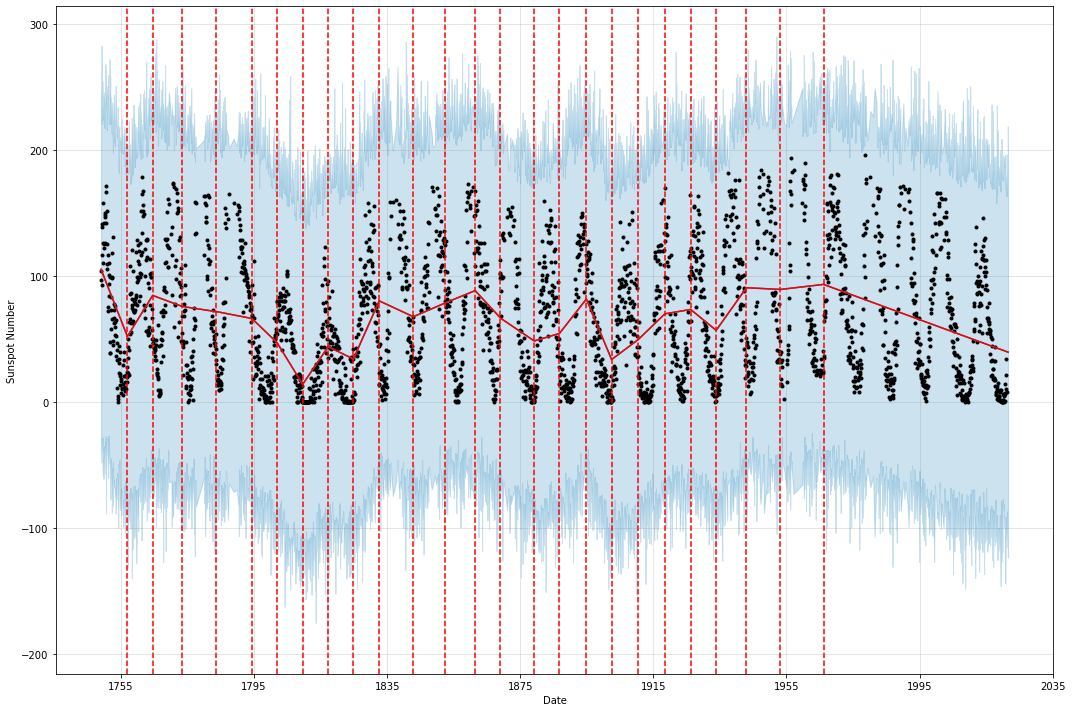

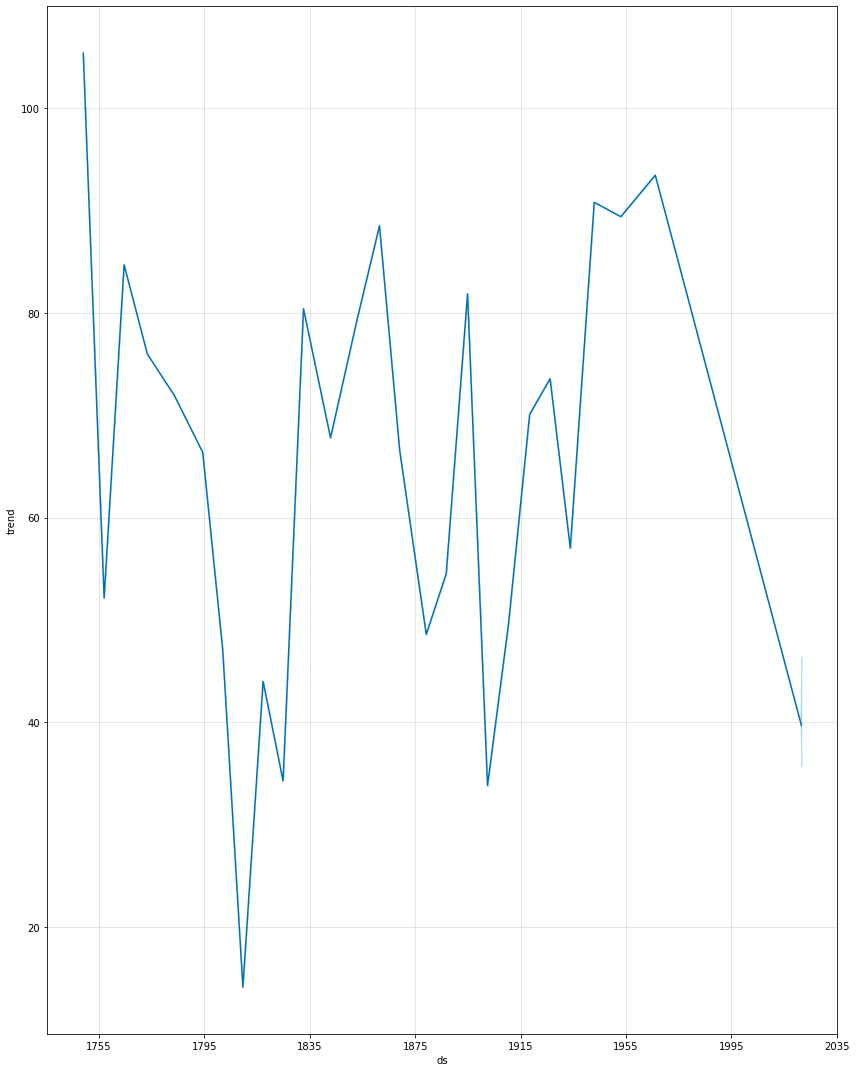

In [26]:
fig = model.plot(forecast_6_month, xlabel = "Date", ylabel = "Sunspot Number", figsize = (15,10))
a= add_changepoints_to_plot(fig.gca(),model,forecast_6_month)
fig1=model.plot_components(forecast_6_month, figsize=(12,15))

### Cross validation and Performance metrics

In [37]:
df_6_monthly_cv = cross_validation(model, initial='70000 days', period='90 days', horizon = '180 days', parallel = 'processes')

INFO:prophet:Making 292 forecasts with cutoffs between 1940-10-17 00:00:00 and 2020-08-18 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc78e6b5040>


In [38]:
df_6_monthly_perf = performance_metrics(df_6_monthly_cv)
df_6_monthly_perf.head()

INFO:prophet:Skipping MAPE because y close to 0


,horizon,mse,rmse,mae,mdape,smape,coverage
0,21 days,2361.159738,48.591766,43.512164,0.570113,0.734396,1.0
1,22 days,2334.674319,48.318468,43.440258,0.570113,0.729949,1.0
2,23 days,2292.616915,47.881279,42.911431,0.570113,0.729257,1.0
3,24 days,2321.714567,48.184173,43.543388,0.543540,0.747230,1.0
4,25 days,2349.212990,48.468681,43.694766,0.543540,0.741999,1.0


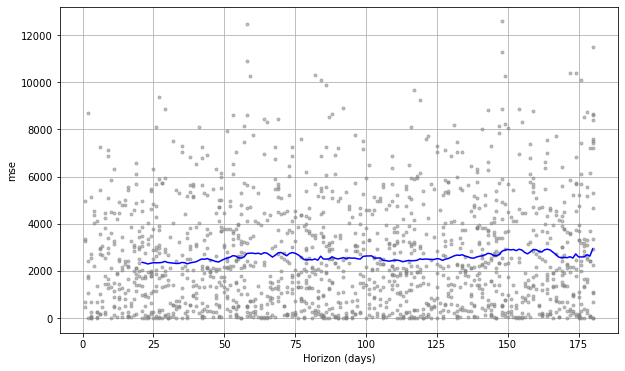

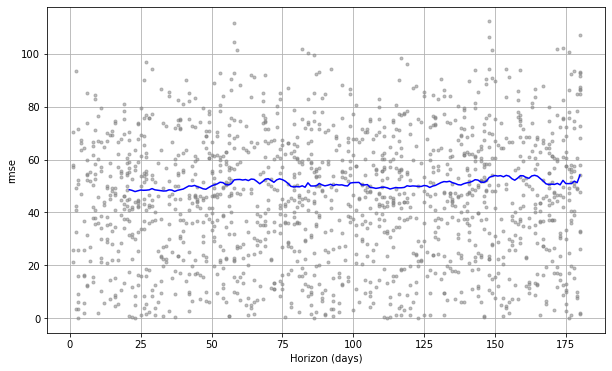

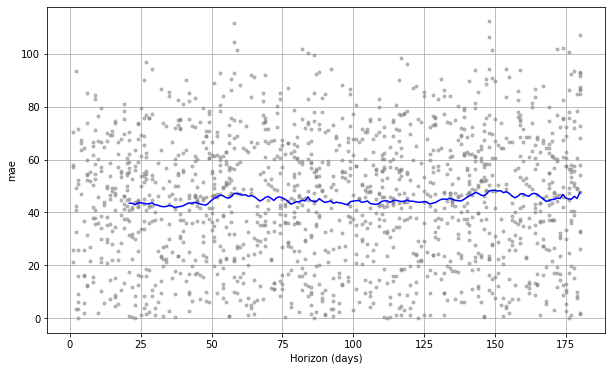

In [39]:
plt_mse = plot_cross_validation_metric(df_6_monthly_cv, metric='mse')

plt_rmse = plot_cross_validation_metric(df_6_monthly_cv, metric='rmse')

plt_mae = plot_cross_validation_metric(df_6_monthly_cv, metric='mae')

#plt_mape = plot_cross_validation_metric(df_6_monthly_cv, metric='mape')

In [40]:
r2_6_monthly= r2_score(df_6_monthly_cv['y'], df_6_monthly_cv['yhat'])
print('R2 Score :')
r2_6_monthly

R2 Score :


0.03199935357042094

## 9 month forecast

In [41]:
future_9_month = model.make_future_dataframe(periods = 9, freq='m')
forecast_9_month = model.predict(future_9_month)
forecast_9_month.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,1749-01-15,105.360321,-36.400514,252.866231,105.360321,105.360321,0.0,0.0,0.0,0.0,0.0,0.0,105.360321
1,1749-02-14,104.808320,-34.838180,245.545448,104.808320,104.808320,0.0,0.0,0.0,0.0,0.0,0.0,104.808320
2,1749-03-15,104.274718,-41.971929,261.199996,104.274718,104.274718,0.0,0.0,0.0,0.0,0.0,0.0,104.274718
3,1749-04-15,103.704316,-18.143002,245.779975,103.704316,103.704316,0.0,0.0,0.0,0.0,0.0,0.0,103.704316
4,1749-05-15,103.152315,-60.199207,251.450972,103.152315,103.152315,0.0,0.0,0.0,0.0,0.0,0.0,103.152315


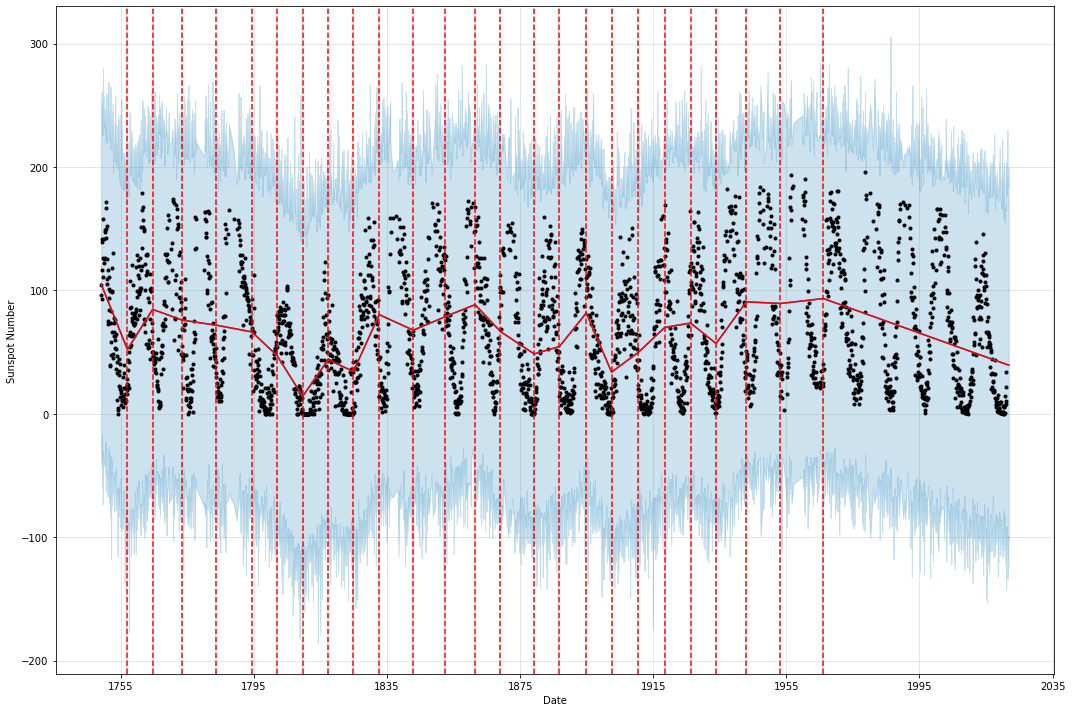

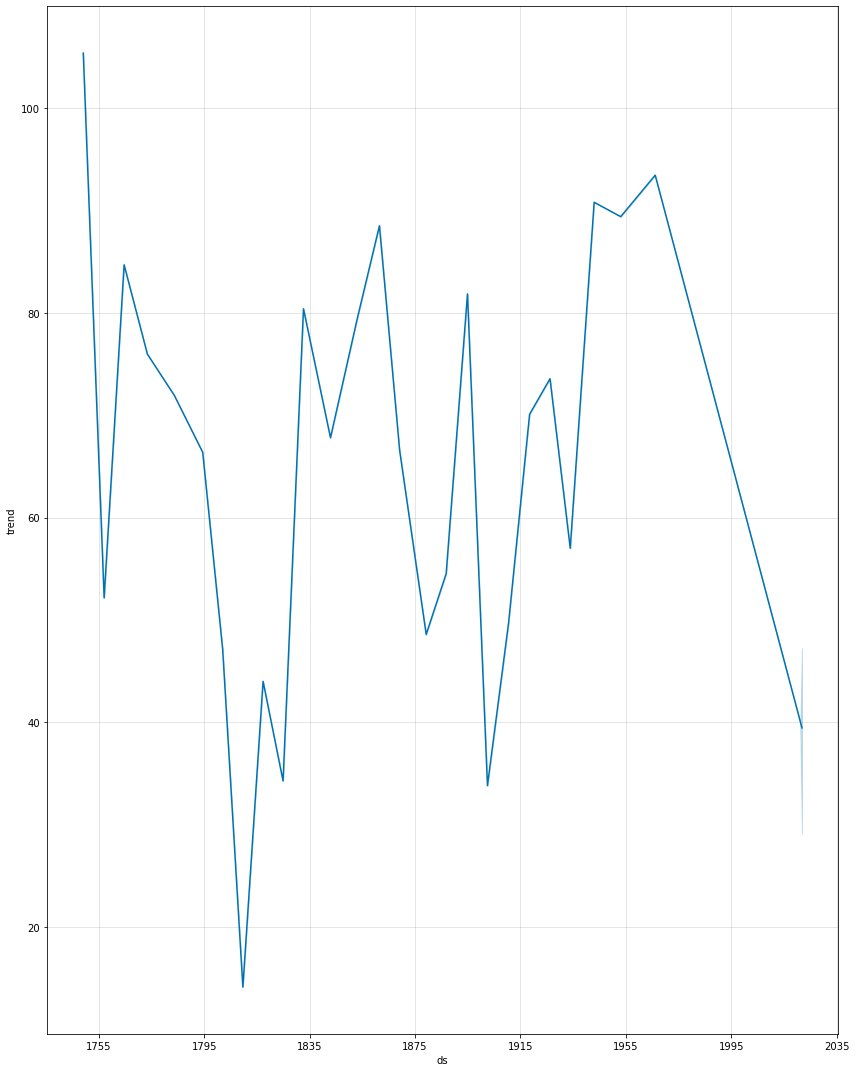

In [42]:
fig = model.plot(forecast_9_month, xlabel = "Date", ylabel = "Sunspot Number", figsize = (15,10))
a= add_changepoints_to_plot(fig.gca(),model,forecast_9_month)
fig1=model.plot_components(forecast_9_month, figsize=(12,15))

### Cross validation and Performance metrics

In [65]:
df_9_monthly_cv = cross_validation(model, initial='95000 days', period='150 days', horizon = '365 days', parallel = 'processes')

INFO:prophet:Making 27 forecasts with cutoffs between 2009-06-12 00:00:00 and 2020-02-15 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc7718f37f0>


In [66]:
df_9_monthly_perf = performance_metrics(df_9_monthly_cv )
df_9_monthly_perf.head()

INFO:prophet:Skipping MAPE because y close to 0


,horizon,mse,rmse,mae,mdape,smape,coverage
0,37 days,1394.096944,37.337608,33.227156,0.541946,0.844589,1.0
1,38 days,1393.924421,37.335297,33.182283,0.541946,0.843771,1.0
2,40 days,1328.073627,36.442745,32.168121,0.511828,0.806283,1.0
3,41 days,1307.309627,36.156737,32.219607,0.511828,0.786584,1.0
4,44 days,1326.552438,36.421868,32.991070,0.511828,0.796730,1.0


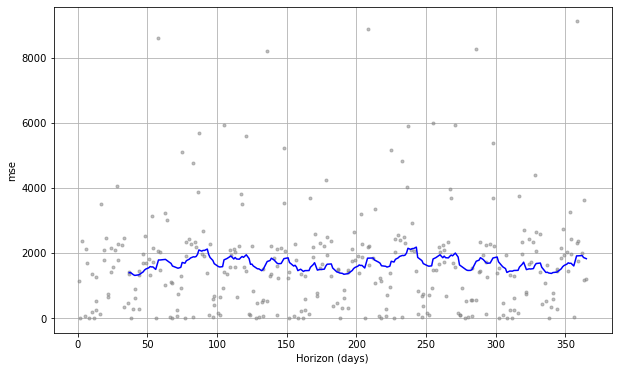

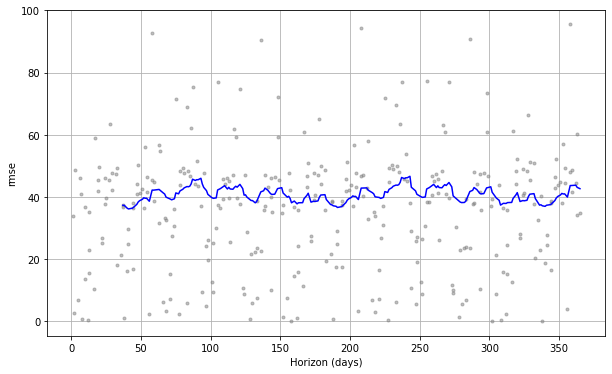

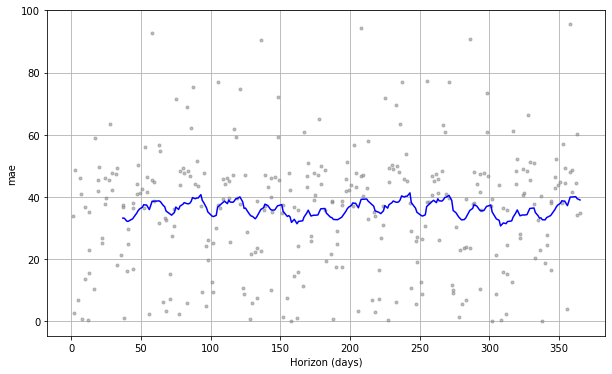

In [68]:
plt_mse = plot_cross_validation_metric(df_9_monthly_cv , metric='mse')

plt_rmse = plot_cross_validation_metric(df_9_monthly_cv , metric='rmse')

plt_mae = plot_cross_validation_metric(df_9_monthly_cv , metric='mae')

#plt_mape = plot_cross_validation_metric(df_9_monthly_cv , metric='mape')

In [69]:
r2_9_monthly= r2_score(df_9_monthly_cv ['y'], df_9_monthly_cv ['yhat'])
print('R2 Score :')
r2_9_monthly

R2 Score :


0.0034702604501241074

# Logistic Model

In [111]:
cap = 220
floor = -100
df_monthly_without_outlier['cap'] = cap
df_monthly_without_outlier['floor'] = floor
m_logistic = Prophet(daily_seasonality = False, yearly_seasonality = False, weekly_seasonality = False,
            seasonality_mode = 'additive',
            growth = 'logistic',
            n_changepoints = 25,
            interval_width = 1.0,
            changepoint_range = 0.8,
            changepoint_prior_scale = 0.5,
            seasonality_prior_scale= 20.0 )
m_logistic.add_seasonality(name='monthly', period=30.5, fourier_order=5)

m_logistic.fit(df_monthly_without_outlier)

## 1 month forecast

In [93]:
future_1_logistic = m_logistic.make_future_dataframe(periods=1, freq='m', include_history = True)
future_1_logistic['cap'] = cap
future_1_logistic['floor'] = floor
forecast_1_logistic= m_logistic.predict(future_1_logistic)
forecast_1_logistic[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
2844,2020-11-15,49.724999,-117.326330,188.186302
2845,2020-12-16,42.106060,-105.181286,189.333860
2846,2021-01-15,49.583861,-71.063441,175.171728
2847,2021-02-14,55.754307,-60.187819,212.773860
2848,2021-02-28,60.724672,-129.796645,192.135477


In [94]:
def seasonality(df, future, name, period, fourier_order):
    model = Prophet(weekly_seasonality=False)
    model.add_seasonality(name=name, period=period, fourier_order=fourier_order)
    forecast = model.fit(df).predict(future)
    fig = model.plot_components(forecast)

INFO:prophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


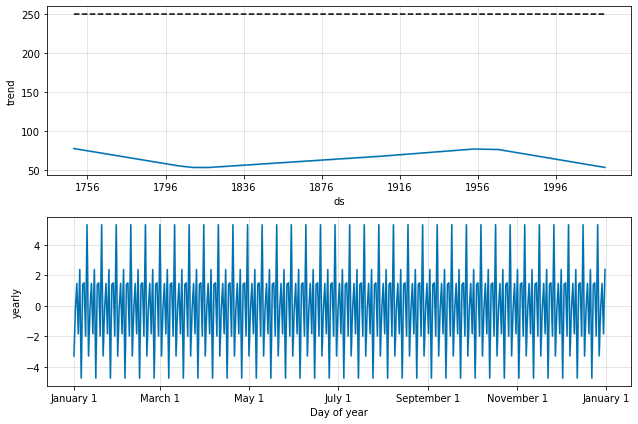

In [95]:
seasonality(df_monthly_without_outlier, future_1_logistic, 'yearly', 10, 4)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


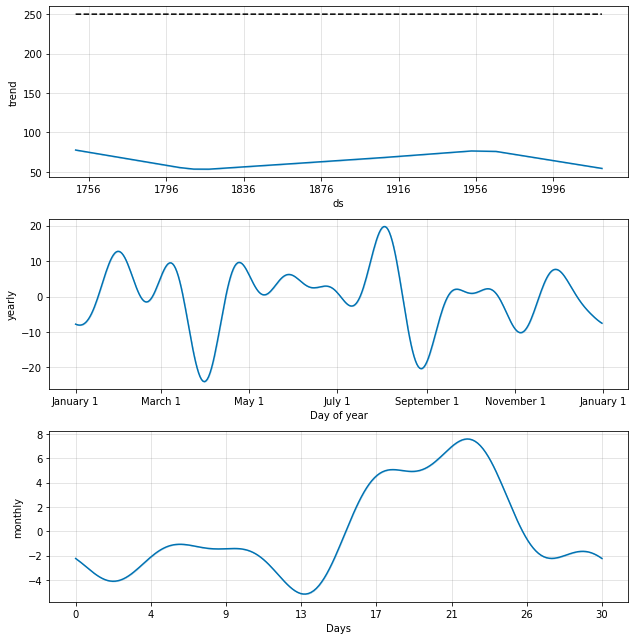

In [96]:
seasonality(df_monthly_without_outlier, future_1_logistic, 'monthly', 30, 5)

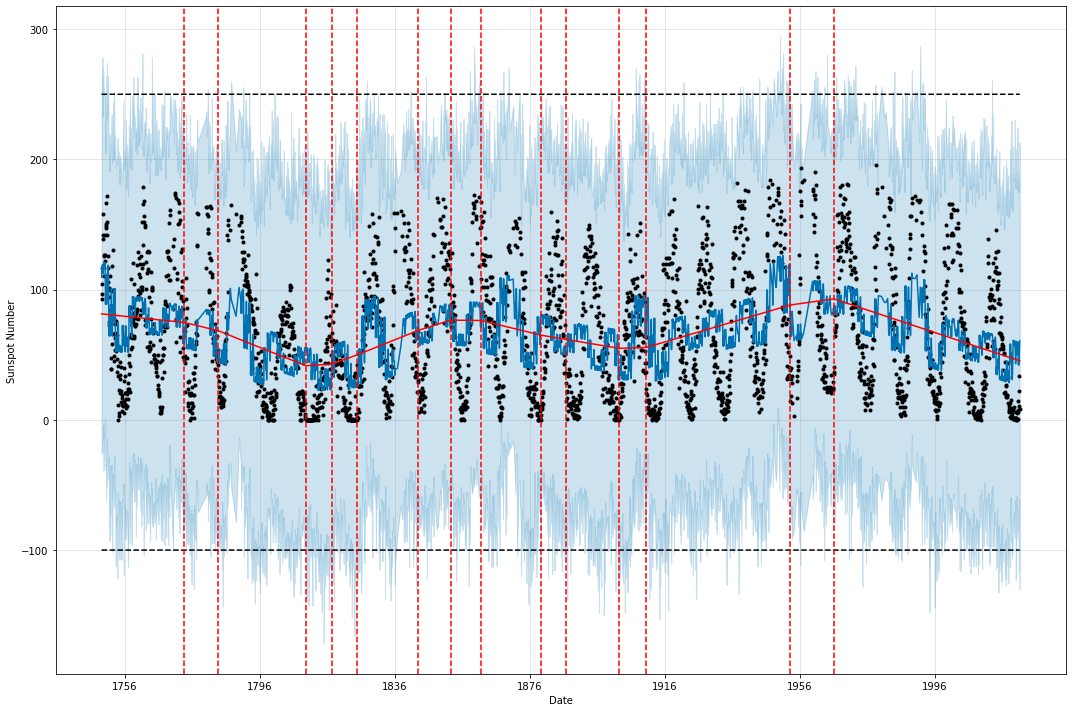

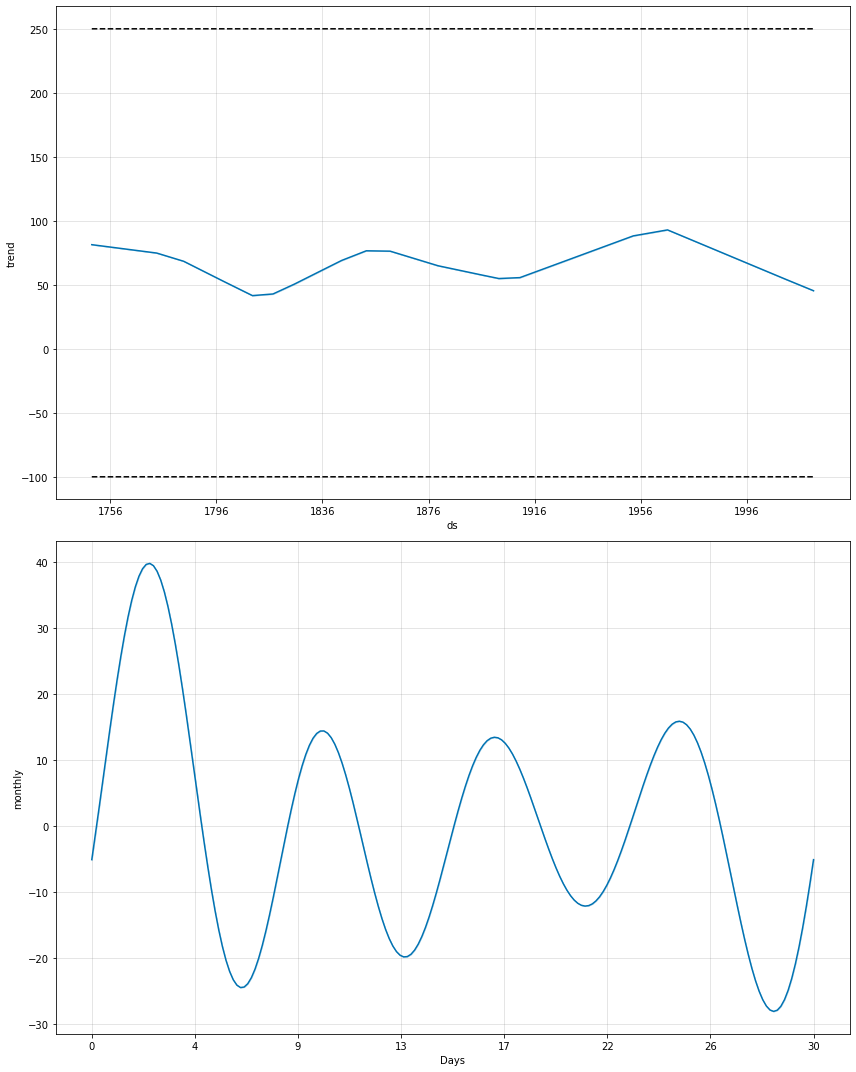

In [110]:
fig = m_logistic.plot(forecast_1_logistic, xlabel = "Date", ylabel = "Sunspot Number", figsize = (15,10))
a= add_changepoints_to_plot(fig.gca(),m_logistic,forecast_1_logistic)
fig1=m_logistic.plot_components(forecast_1_logistic, figsize=(12,15))

### Cross validation and Performance Metrics

In [98]:
df_1_monthly_logistic_cv = cross_validation(m_logistic, initial='95000 days', period='100 days', horizon = '365 days', parallel = 'processes')

INFO:prophet:Making 41 forecasts with cutoffs between 2009-03-04 00:00:00 and 2020-02-15 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc78d06b460>


In [99]:
df_1_monthly_logistic_perf = performance_metrics(df_1_monthly_logistic_cv)
df_1_monthly_logistic_perf.head()

INFO:prophet:Skipping MAPE because y close to 0


,horizon,mse,rmse,mae,mdape,smape,coverage
0,37 days,2443.280007,49.429546,43.387951,0.610941,0.911756,1.0
1,38 days,2451.856644,49.516226,43.769291,0.610941,0.916715,1.0
2,39 days,2374.477027,48.728606,43.010856,0.619312,0.936829,1.0
3,41 days,2362.760759,48.608238,42.811977,0.610941,0.922632,1.0
4,42 days,2457.900453,49.577217,43.768052,0.610941,0.942712,1.0


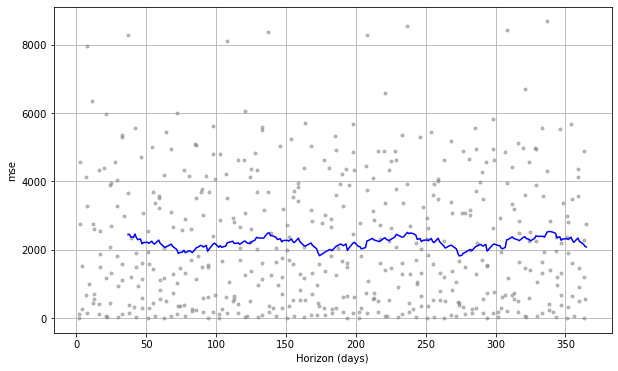

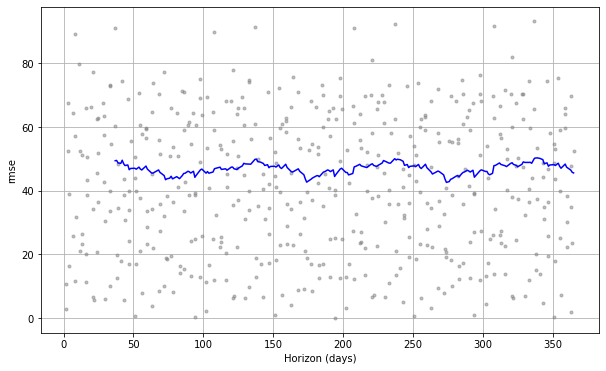

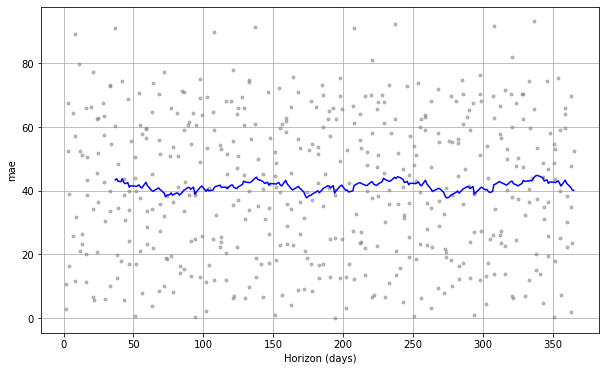

In [100]:
plt_mse = plot_cross_validation_metric(df_1_monthly_logistic_cv, metric='mse')

plt_rmse = plot_cross_validation_metric(df_1_monthly_logistic_cv, metric='rmse')

plt_mae = plot_cross_validation_metric(df_1_monthly_logistic_cv, metric='mae')

#plt_mape = plot_cross_validation_metric(df_1_monthly_logistic_cv, metric='mape')

In [101]:
r2_1_monthly_logistic= r2_score(df_1_monthly_logistic_cv['y'], df_1_monthly_logistic_cv['yhat'])
print('R2 score for logistic model :')
r2_1_monthly_logistic

R2 score for logistic model :


-0.2983680473627921

## 6 month forecast

In [112]:
future_6_logistic = m_logistic.make_future_dataframe(periods=6, freq='m', include_history = True)
future_6_logistic['cap'] = cap
future_6_logistic['floor'] = floor
forecast_6_logistic= m_logistic.predict(future_6_logistic)
forecast_6_logistic[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
2849,2021-03-31,60.499115,-67.016005,199.103864
2850,2021-04-30,60.096350,-66.299458,199.878027
2851,2021-05-31,60.353838,-60.669134,193.629959
2852,2021-06-30,59.951086,-79.928650,237.038451
2853,2021-07-31,60.208586,-71.190418,183.064846


INFO:prophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


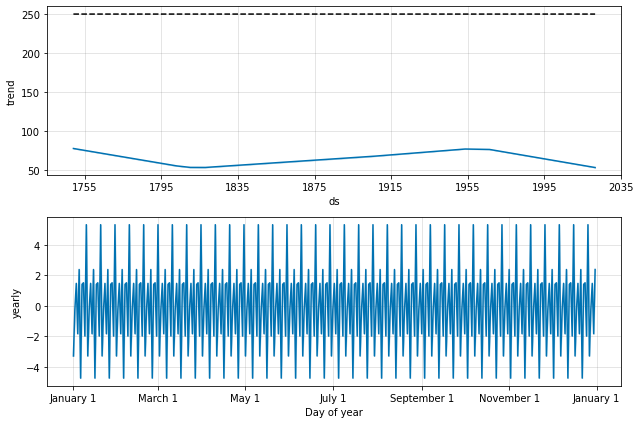

In [103]:
seasonality(df_monthly_without_outlier, future_6_logistic, 'yearly', 10, 4)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


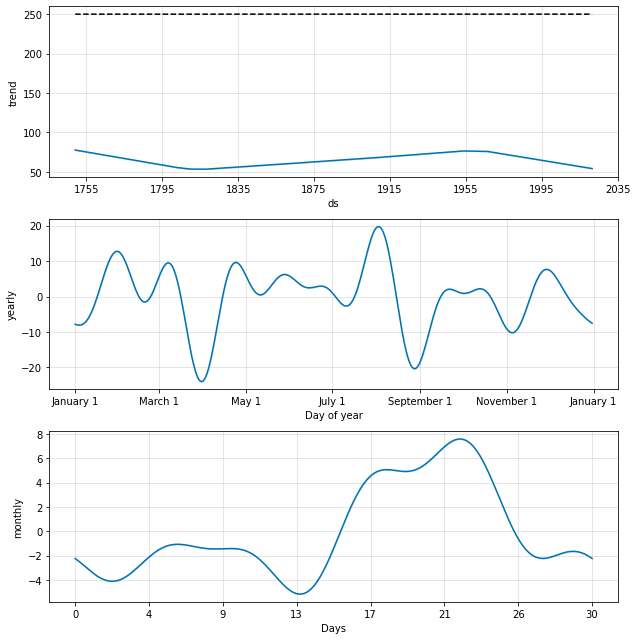

In [104]:
seasonality(df_monthly_without_outlier, future_6_logistic, 'monthly', 30, 5)

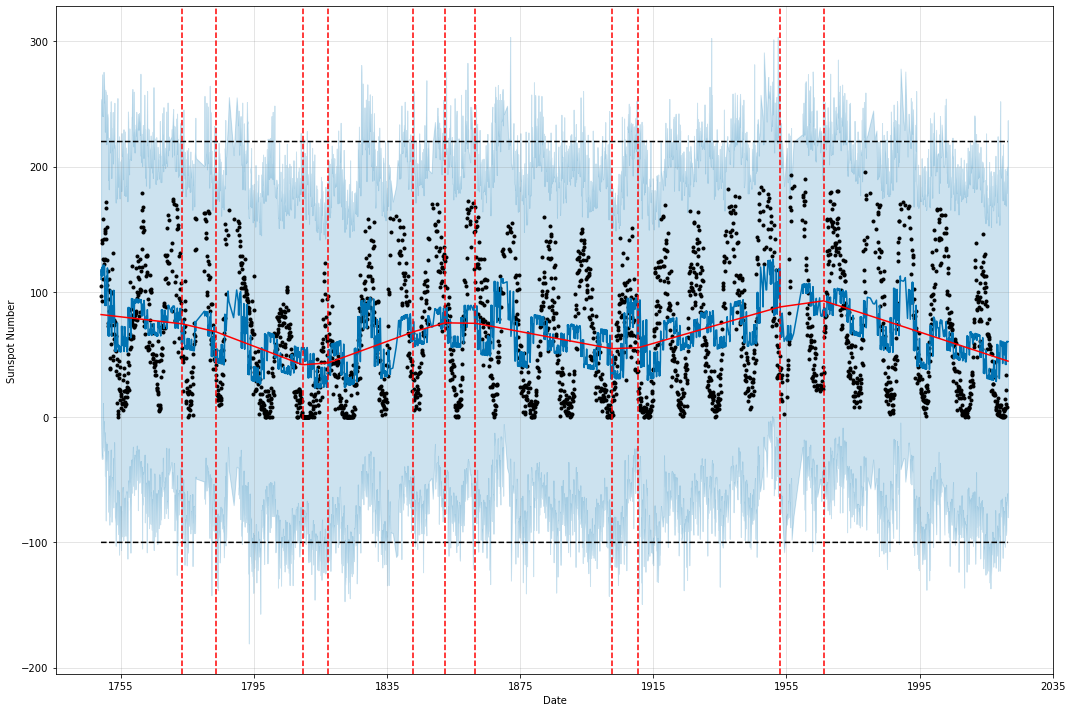

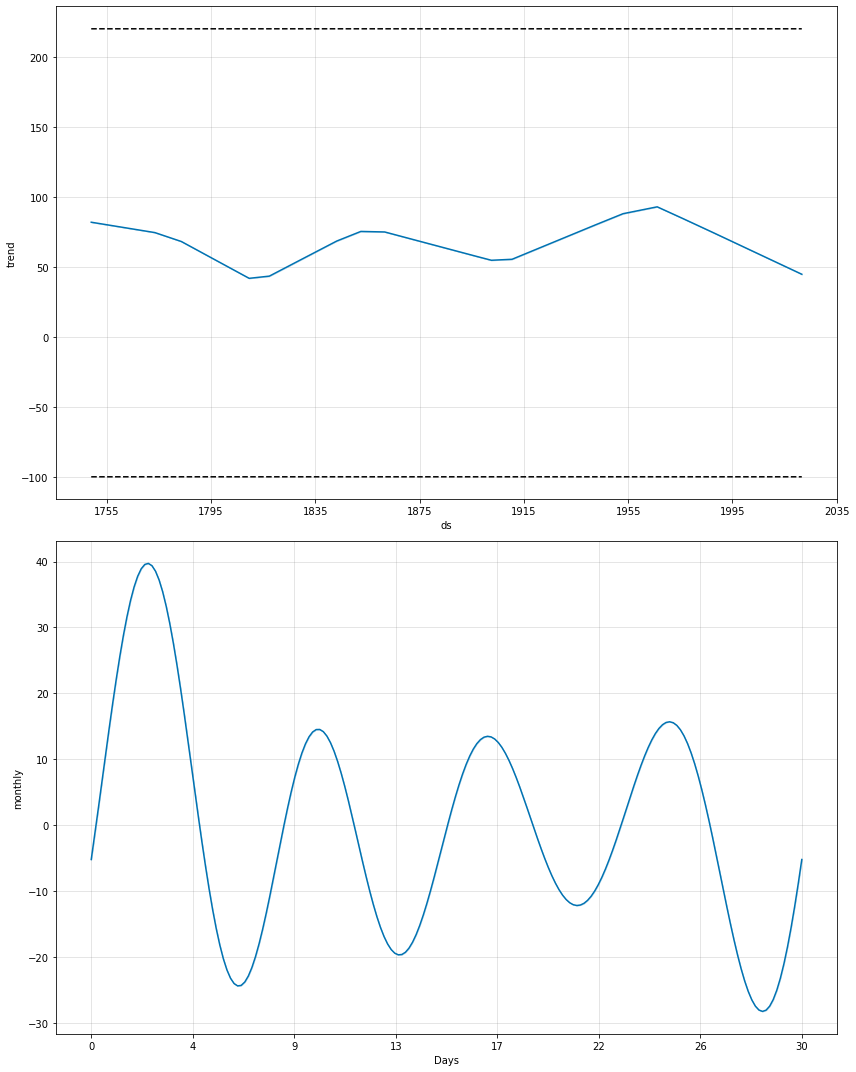

In [113]:
fig = m_logistic.plot(forecast_6_logistic, xlabel = "Date", ylabel = "Sunspot Number", figsize = (15,10))
a= add_changepoints_to_plot(fig.gca(),m_logistic,forecast_6_logistic)
fig1=m_logistic.plot_components(forecast_6_logistic, figsize=(12,15))

### Cross validation and Performance metrics

In [119]:
df_6_monthly_logistic_cv = cross_validation(m_logistic, initial='94000 days', period='150 days', horizon = '300 days', parallel = 'processes')

INFO:prophet:Making 34 forecasts with cutoffs between 2006-10-01 00:00:00 and 2020-04-20 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc7720f61f0>


In [120]:
df_6_monthly_logistic_perf = performance_metrics(df_6_monthly_logistic_cv)
df_6_monthly_logistic_perf.head()

INFO:prophet:Skipping MAPE because y close to 0


,horizon,mse,rmse,mae,mdape,smape,coverage
0,29 days,2707.559279,52.034213,47.047114,2.244133,1.073400,1.0
1,30 days,2800.079237,52.915775,48.227675,2.407813,1.111085,1.0
2,32 days,2754.186891,52.480348,47.694139,2.407813,1.093412,1.0
3,33 days,2764.777467,52.581151,48.006320,1.892675,1.099966,1.0
4,36 days,2746.564509,52.407676,47.427387,1.892675,1.088635,1.0


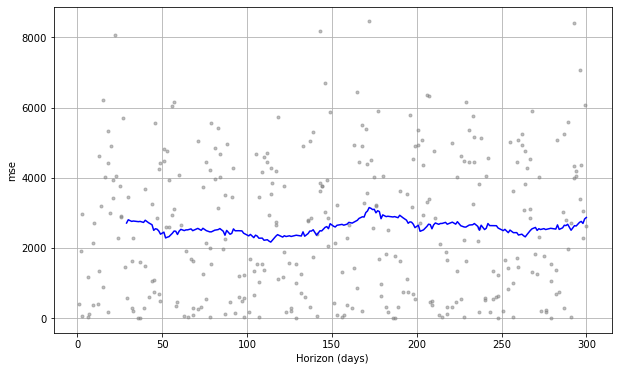

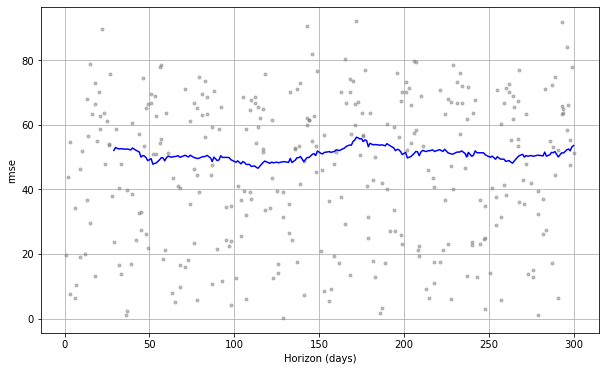

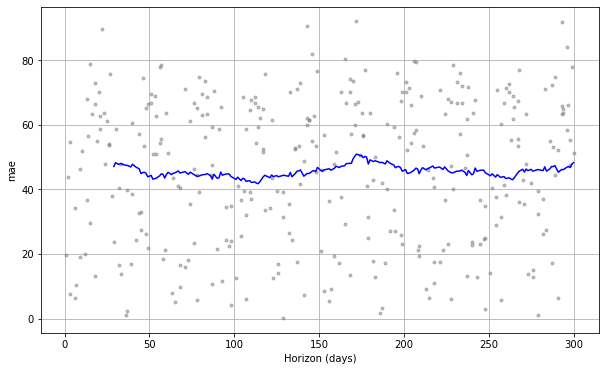

In [122]:
plt_mse = plot_cross_validation_metric(df_6_monthly_logistic_cv, metric='mse')

plt_rmse = plot_cross_validation_metric(df_6_monthly_logistic_cv, metric='rmse')

plt_mae = plot_cross_validation_metric(df_6_monthly_logistic_cv, metric='mae')

#plt_mape = plot_cross_validation_metric(df_6_monthly_logistic_cv, metric='mape')

In [123]:
r2_6_monthly_logistic= r2_score(df_6_monthly_logistic_cv['y'], df_6_monthly_logistic_cv['yhat'])
print('R2 score for logistic model :')
r2_6_monthly_logistic

R2 score for logistic model :


-0.5894454710583197

## 9 month forecast

In [124]:
future_9_logistic = m_logistic.make_future_dataframe(periods=10, freq='m', include_history = True)
future_9_logistic['cap'] = cap
future_9_logistic['floor'] = floor
forecast_9_logistic= m_logistic.predict(future_9_logistic)
forecast_9_logistic[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
2853,2021-07-31,60.208586,-65.309680,190.298672
2854,2021-08-31,57.773526,-55.946648,183.016039
2855,2021-09-30,60.063359,-60.929871,181.101754
2856,2021-10-31,57.628312,-83.865706,199.053080
2857,2021-11-30,59.918158,-72.104404,205.358831


INFO:prophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


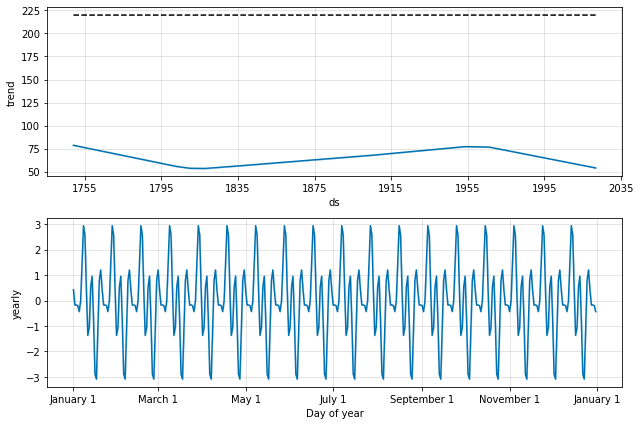

In [125]:
seasonality(df_monthly_without_outlier, future_9_logistic, 'yearly', 20, 4)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


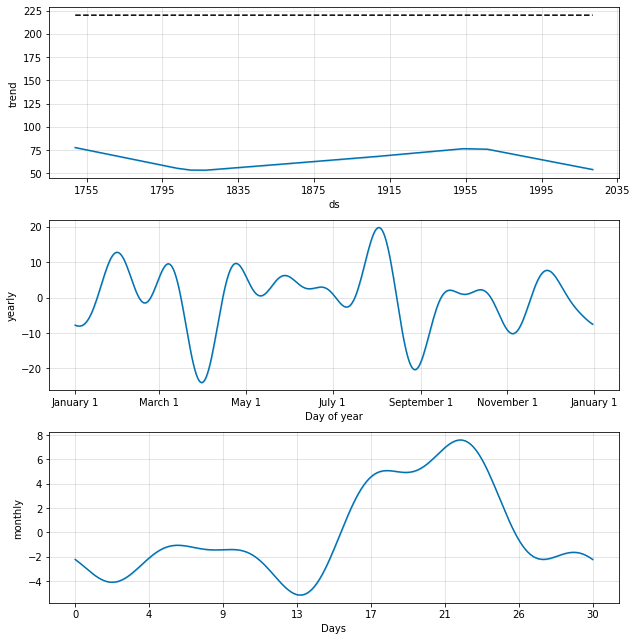

In [126]:
seasonality(df_monthly_without_outlier, future_9_logistic, 'monthly', 30, 5)

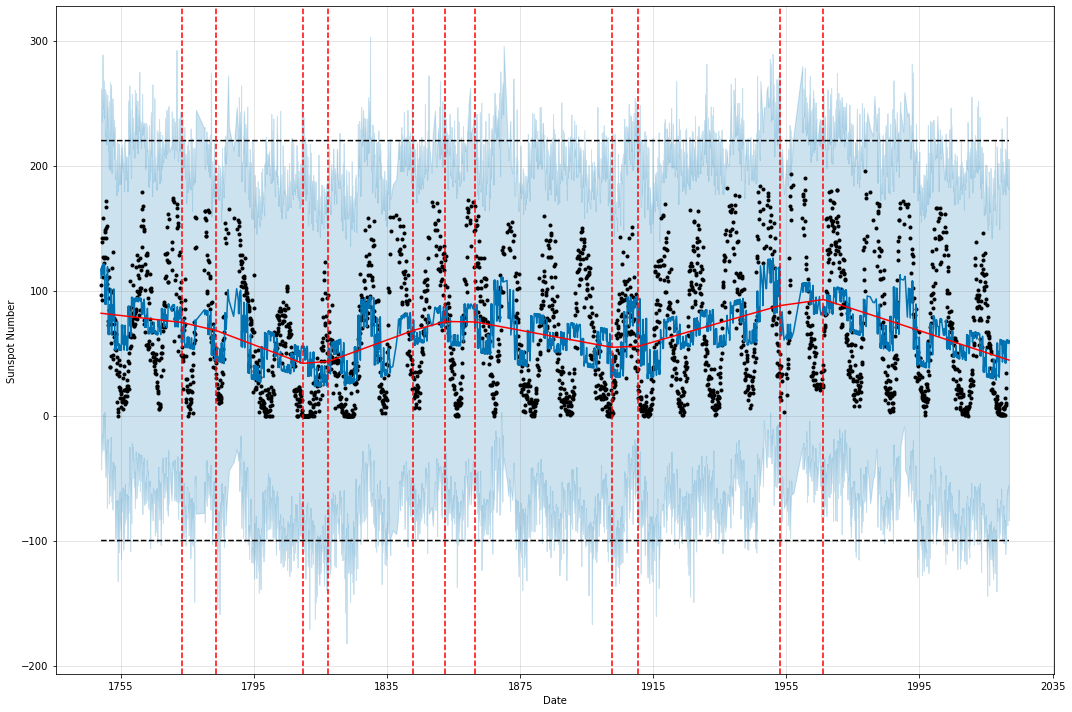

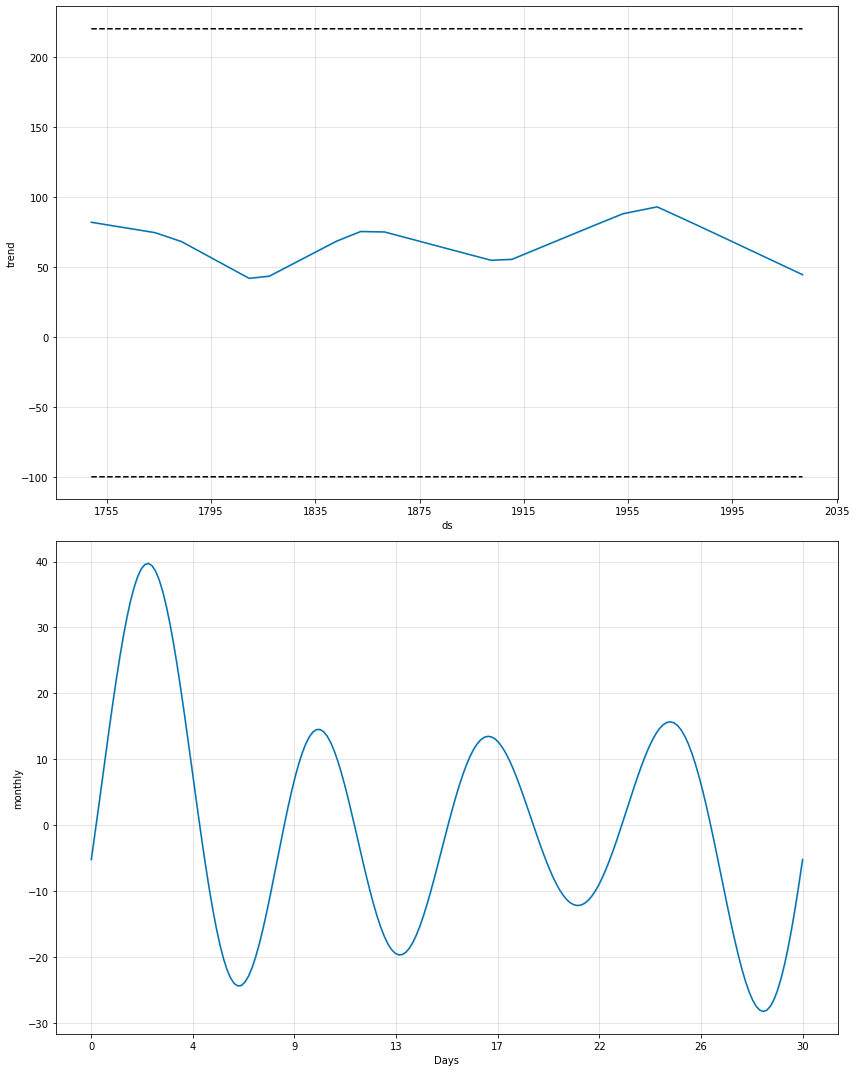

In [127]:
fig = m_logistic.plot(forecast_9_logistic, xlabel = "Date", ylabel = "Sunspot Number", figsize = (15,10))
a= add_changepoints_to_plot(fig.gca(),m_logistic,forecast_9_logistic)
fig1=m_logistic.plot_components(forecast_9_logistic, figsize=(12,15))

### Cross validation and Performance metrics

In [145]:
df_9_monthly_logistic_cv = cross_validation(m_logistic, initial='98000 days', period='50 days', horizon = '100 days', parallel = 'processes')

INFO:prophet:Making 26 forecasts with cutoffs between 2017-06-05 00:00:00 and 2020-11-06 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc774a008b0>


In [146]:
df_9_monthly_logistic_perf = performance_metrics(df_9_monthly_logistic_cv )
df_9_monthly_logistic_perf.head()

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,9 days,2350.818724,48.485242,46.059896,10.444062,7.234289,1.389816,1.0
1,12 days,2641.454773,51.395085,48.827815,30.024711,7.781885,1.458802,1.0
2,13 days,2598.597258,50.976438,48.257082,25.873877,7.044982,1.431263,1.0
3,14 days,2743.308674,52.376604,49.491373,30.013428,7.044982,1.464416,1.0
4,16 days,3005.618605,54.823522,52.340210,31.751970,9.861470,1.543422,1.0


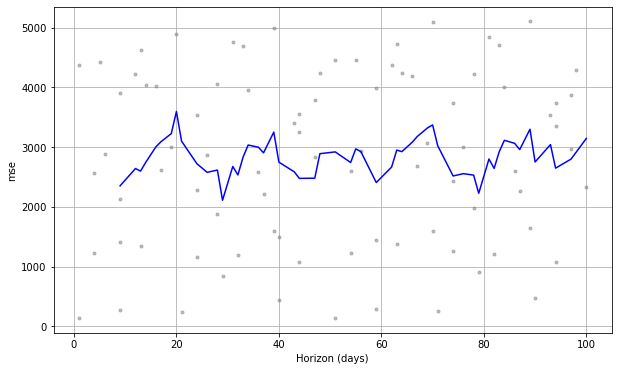

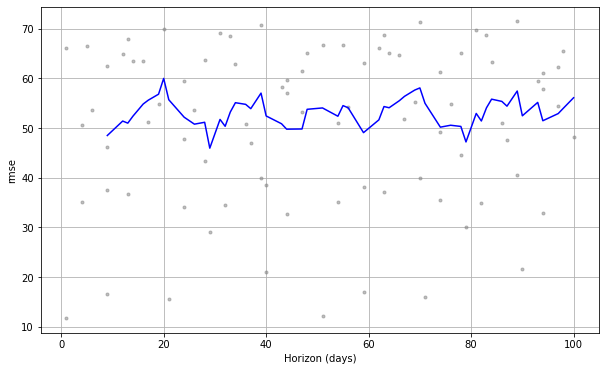

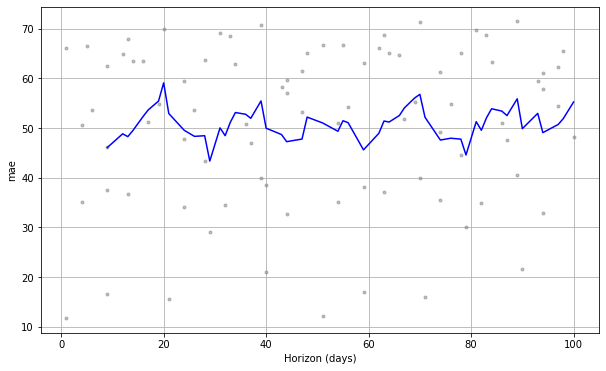

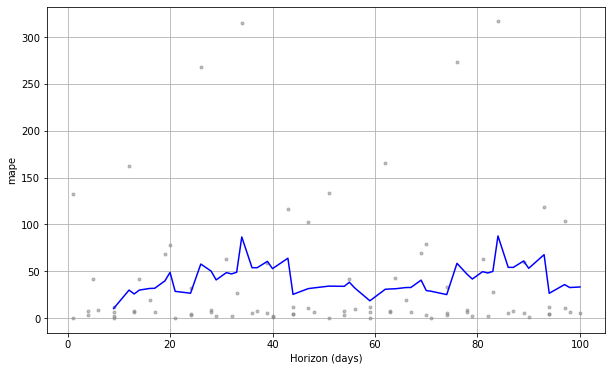

In [147]:
plt_mse = plot_cross_validation_metric(df_9_monthly_logistic_cv , metric='mse')

plt_rmse = plot_cross_validation_metric(df_9_monthly_logistic_cv , metric='rmse')

plt_mae = plot_cross_validation_metric(df_9_monthly_logistic_cv , metric='mae')

plt_mape = plot_cross_validation_metric(df_9_monthly_logistic_cv , metric='mape')

In [148]:
r2_9_monthly_logistic= r2_score(df_9_monthly_logistic_cv ['y'], df_9_monthly_logistic_cv ['yhat'])
print('R2 score for logistic model :')
r2_9_monthly_logistic

R2 score for logistic model :


-30.739509471891548